In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import ShuffleSplit, KFold
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)
from functools import partial



#  Chapter specifc imports
from pygam import (s as s_gam, f as f_gam, LinearGAM, LogisticGAM, l as l_gam)
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)   

#### Question 1


In [2]:
data = load_data("Wage")
data.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


Finished 0 with RSS: 1501086.21
--------------------------------------------------
Finished 1 with RSS: 1433093.91
--------------------------------------------------
Finished 2 with RSS: 1431297.26
--------------------------------------------------
Finished 3 with RSS: 1430614.02
--------------------------------------------------


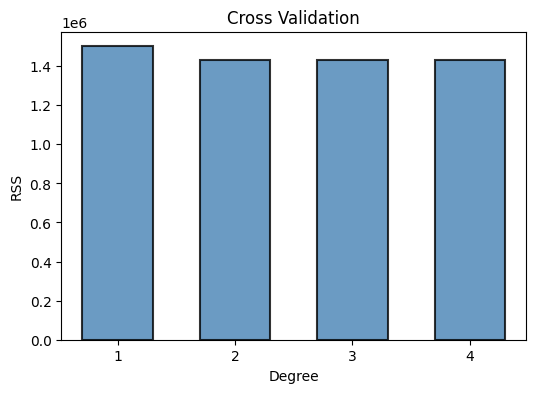

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.602458  2.353254e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.889400  1.678616e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.810061  5.103865e-02


In [3]:
# Age -> Wage -> CrossValidation (d) -> Anova -> Plot
models = [MS([poly("age", degree=i)]).fit(data) for i in range(1, 5)]
x_dat = [m.transform(data) for m in models]

y = data["wage"]

split = 5
cv = ShuffleSplit(n_splits=split, test_size=0.3, random_state=42)
rss_vals = np.array([])

# Cross Validation
for i,x in enumerate(x_dat) : 
    rss = 0
    for train_idx, test_idx in cv.split(x) : 
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model = sm.OLS(y_train, x_train).fit()
        y_pred = model.predict(x_test)
        rss += np.sum((y_test - y_pred) ** 2)
    rss = rss / split
    rss_vals = np.append(rss_vals, rss)
    print(f"Finished {i} with RSS: {rss:.2f}")
    print("-" * 50)
    
# Plotting the Cross Validation
degrees = np.arange(1, 5)
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(degrees, rss_vals, width=0.6, color='steelblue', 
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_xticks(degrees)
ax.set_title("Cross Validation")
ax.set_xlabel("Degree")
ax.set_ylabel("RSS")
plt.show()


# ANOVA
f_test = anova_lm(*[sm.OLS(y,x).fit() for x in x_dat], typ=1)
print(f_test)

# Plotting
age_grid = np.linspace(data['age'].min(), data['age'].max(), 1000)
age = data['age']
y = data['wage']

age_df = pd.DataFrame({'age': age_grid}) # This line was causing the problem
design = MS([poly("age", degree=2)]).fit(data)
x = design.transform(data)
x_new = design.transform(age_df)
model = sm.OLS(y, x).fit()
preds = model.get_prediction(x_new) # This function houses the conf band
bands = preds.conf_int(alpha=0.05)


Best degree that explain is degree `2` as confirmed by both bar chart and anova table. 

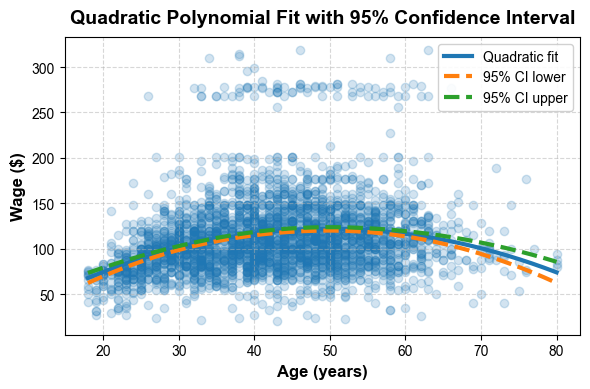

In [4]:
# Plotting the results
labels = ['Quadratic fit', '95% CI lower', '95% CI upper']
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(age, y, alpha=0.2)
for val, ls, label in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['-', '--', '--'], labels):
    ax.plot(age_grid, val, ls=ls, linewidth=3, label=label)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Age (years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Wage ($)', fontsize=12, fontweight='bold')
ax.set_title('Quadratic Polynomial Fit with 95% Confidence Interval', 
             fontsize=14, fontweight='bold', pad=10)
ax.legend(loc='upper right', framealpha=0.9, frameon=True, fontsize=10)
plt.style.use('seaborn-v0_8')
plt.tight_layout()
plt.show()

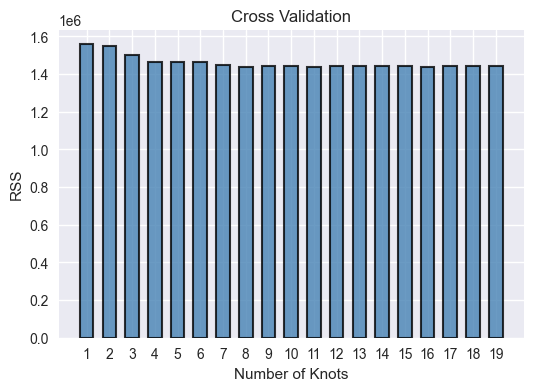

In [5]:
# To fit step function using age with optimal number of knots
knots = np.arange(1,20)
cv = ShuffleSplit(n_splits=split, test_size=0.3, random_state=42)
rss_vals = np.array([])

for knot in knots : 
    rss = 0
    for train_idx, test_idx in cv.split(x) : 
        cut_age = pd.cut(age, knot)
        cut_age = pd.get_dummies(cut_age)
        x_train, x_test = cut_age.iloc[train_idx], cut_age.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model = sm.OLS(y_train, x_train).fit()
        y_pred = model.predict(x_test)
        rss += np.sum((y_test - y_pred) ** 2)
    rss = rss / split
    rss_vals = np.append(rss_vals, rss)
    
# Plotting the Cross Validation
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(knots, rss_vals, width=0.6, color='steelblue', 
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_xticks(knots)
ax.set_title("Cross Validation")
ax.set_xlabel("Number of Knots")
ax.set_ylabel("RSS")
plt.show()

Optimal Number of Knots : 7

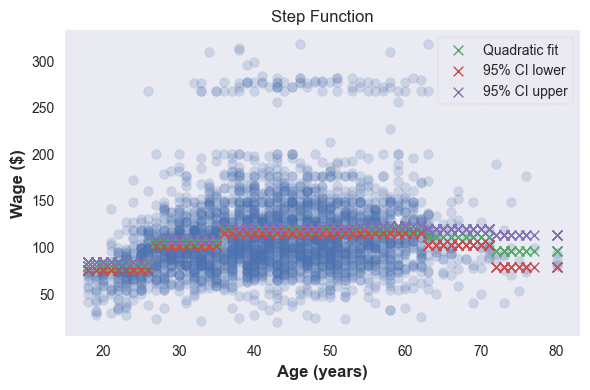

In [6]:
cut_age = pd.cut(age, 7)
cut_age = pd.get_dummies(cut_age)
model = sm.OLS(y, cut_age).fit()
preds = model.get_prediction(cut_age)
bands = preds.conf_int(alpha=0.05)

# Plotting the results
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(age, y, alpha=0.2)
for val, ls, label in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['-', '--', '--'], labels):
    ax.scatter(age, val, marker='x', alpha=1, linewidth=1, label=label)
ax.grid(True, linestyle='--', alpha=0.1)
ax.set_xlabel('Age (years)', fontsize=12, fontweight='bold')
ax.set_title("Step Function")
ax.set_ylabel('Wage ($)', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', framealpha=0.9, frameon=True, fontsize=10)
plt.style.use('seaborn-v0_8')
plt.tight_layout()
plt.show()

#### Question 2

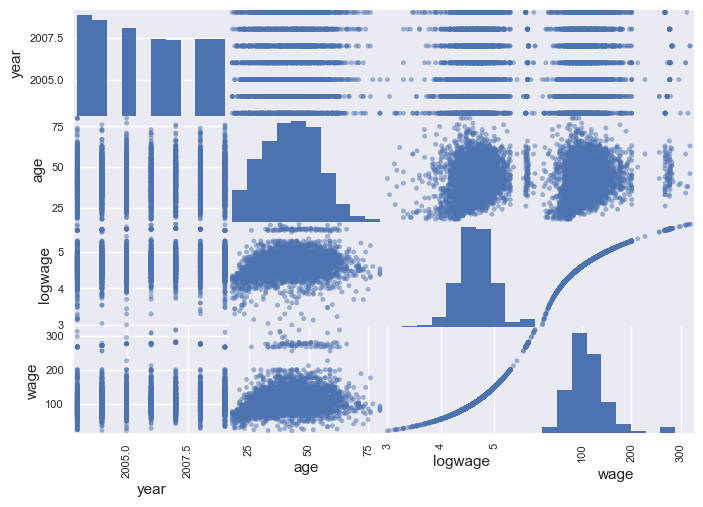

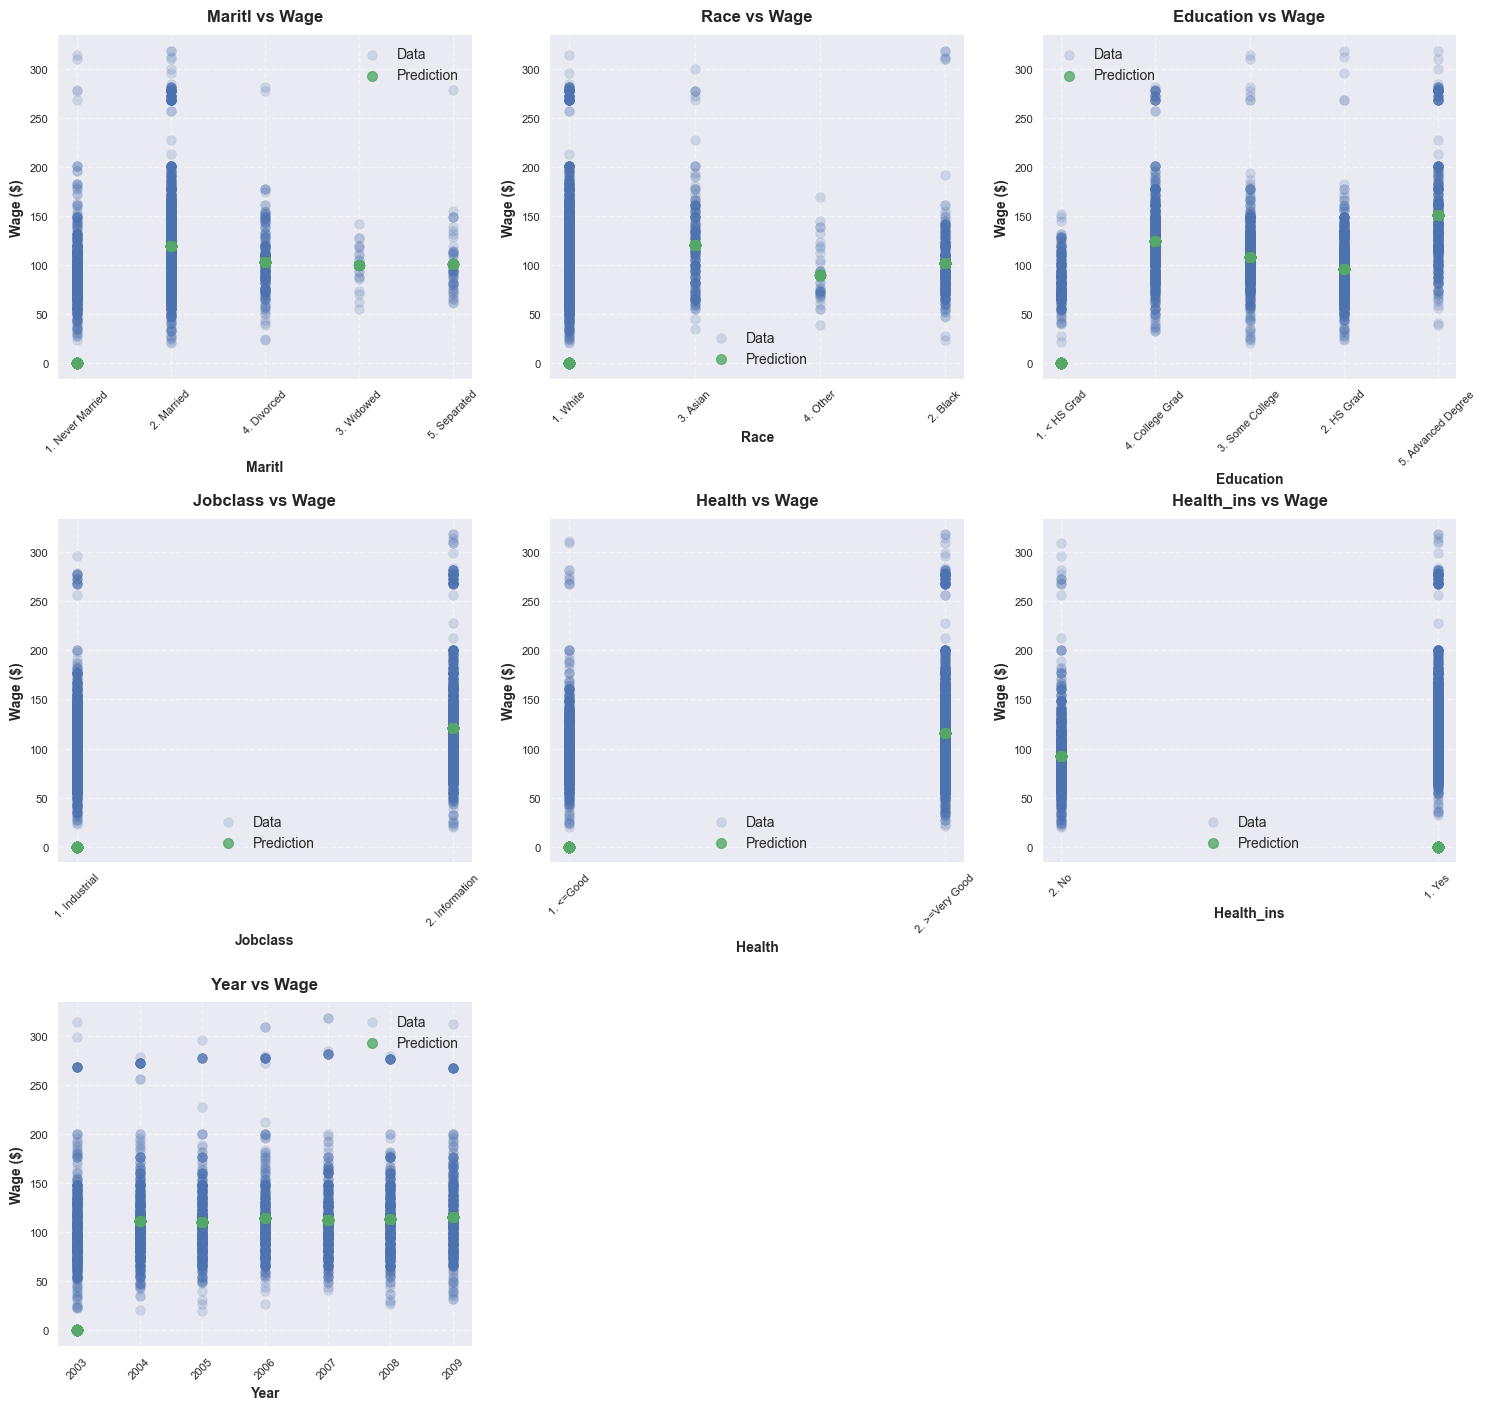

In [7]:
# Explore the relationships between other predictors and wage
# Best way is to create a scatter plot

data = load_data("Wage")
data.head()

pd.plotting.scatter_matrix(data)

categorical_cols = ['maritl', 'race', 'education', 'jobclass', 'health', 'health_ins', "year"]

n_cols = 3  # Number of columns in the grid
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols  # Calculate number of rows

# Plotting
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() 

for i, col in enumerate(categorical_cols):
    dummies = pd.get_dummies(data[col], drop_first=True)
    model = sm.OLS(y, dummies).fit()
    preds = model.get_prediction(dummies)
    ax = axes[i]
    ax.scatter(data[col], y, alpha=0.2, label='Data')
    ax.scatter(data[col], preds.predicted_mean, marker='o', alpha=0.8, 
               linewidth=1, label='Prediction')
    
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlabel(col.capitalize(), fontsize=10, fontweight='bold')
    ax.set_ylabel('Wage ($)', fontsize=10, fontweight='bold')
    ax.set_title(f"{col.capitalize()} vs Wage", fontsize=12, fontweight='bold', pad=10)
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

    ax.tick_params(axis='both', which='major', labelsize=8)
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()



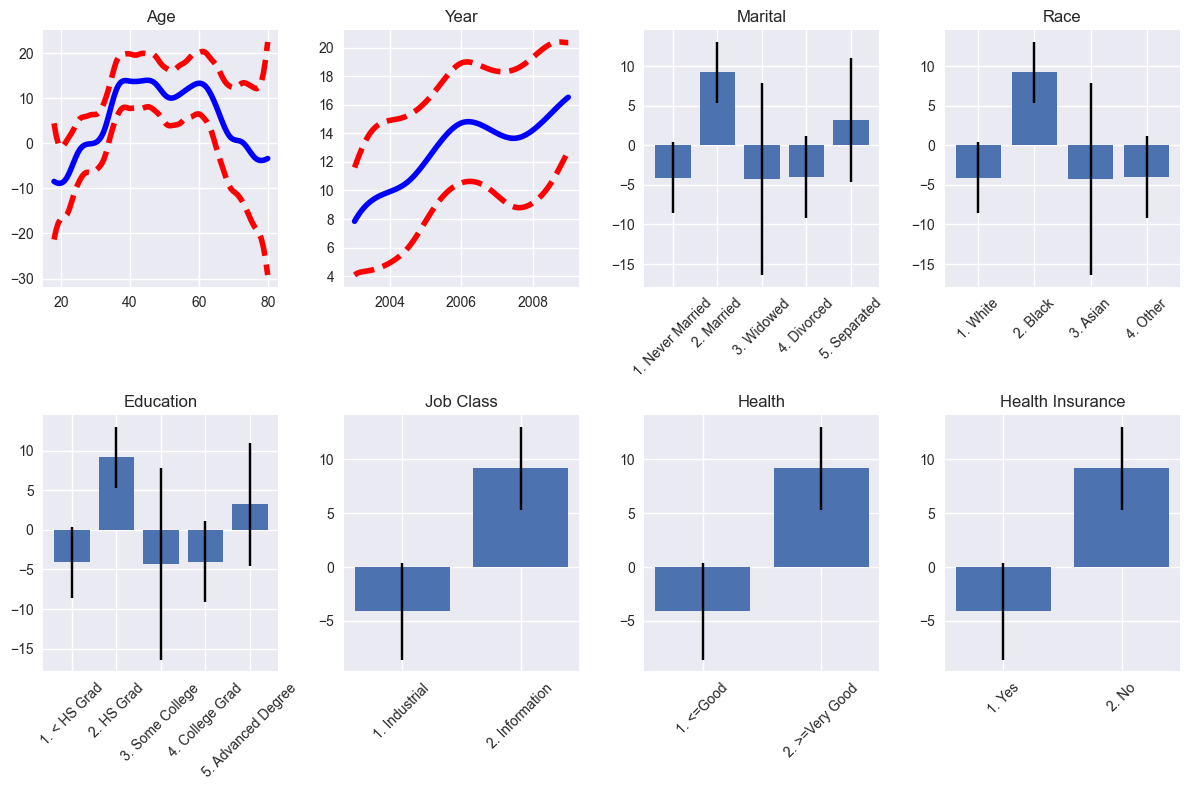

In [8]:
# I think partial dependence plots are going to be good ways to visulize the effects.
# GAMs are great f - factor ; s - smoothing ; l - linear

# Categorical Variables - Not including regions
mari = data["maritl"].cat.codes
race = data["race"].cat.codes
edu = data["education"].cat.codes
job = data["jobclass"].cat.codes
health = data["health"].cat.codes
health_ins = data["health_ins"].cat.codes
age = data.loc[:, "age"]
year  = data.loc[:, "year"]
wage = data.loc[:, "wage"]

gam = LinearGAM(s_gam(0) + s_gam(1, n_splines=7) + f_gam(2) + f_gam(3) + f_gam(4) + f_gam(5) + f_gam(6) + f_gam(7))
xs = np.column_stack([age, year, mari, race, edu, job, health, health_ins])
gam_fit = gam.fit(xs, wage)

# Plotting
fig, ax = plt.subplots(2,4,figsize=(12,8))
plot_gam(gam_fit, 0, ax=ax[0,0])
plot_gam(gam_fit, 1, ax=ax[0,1])
plot_gam(gam_fit, 2, ax=ax[0,2])
plot_gam(gam_fit, 3, ax=ax[0,3])
plot_gam(gam_fit, 4, ax=ax[1,0])
plot_gam(gam_fit, 5, ax=ax[1,1])
plot_gam(gam_fit, 6, ax=ax[1,2])
plot_gam(gam_fit, 7, ax=ax[1,3])
ax[0,0].set_title("Age")
ax[0,1].set_title("Year")
ax[0,2].set_title("Marital")
ax[0,2].set_xticklabels(data["maritl"].cat.categories, rotation=45)
ax[0,3].set_title("Race")
ax[0,3].set_xticklabels(data["race"].cat.categories, rotation=45)
ax[1,0].set_title("Education")
ax[1,0].set_xticklabels(data["education"].cat.categories, rotation=45)
ax[1,1].set_title("Job Class")
ax[1,1].set_xticklabels(data["jobclass"].cat.categories, rotation=45)
ax[1,2].set_title("Health")
ax[1,2].set_xticklabels(data["health"].cat.categories, rotation=45)
ax[1,3].set_title("Health Insurance")
ax[1,3].set_xticklabels(data["health_ins"].cat.categories, rotation=45)
plt.tight_layout()
plt.show()

Most of the partial plots agree with the individual plots, really suprising to see people with health insurance having less wages - which totally makes sense

Also we need to interpret the plots in relative sense.

#### Question 3

In [9]:
# Explore the non linear relationships in Auto Dataset
data = load_data("Auto")
data.head() 

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


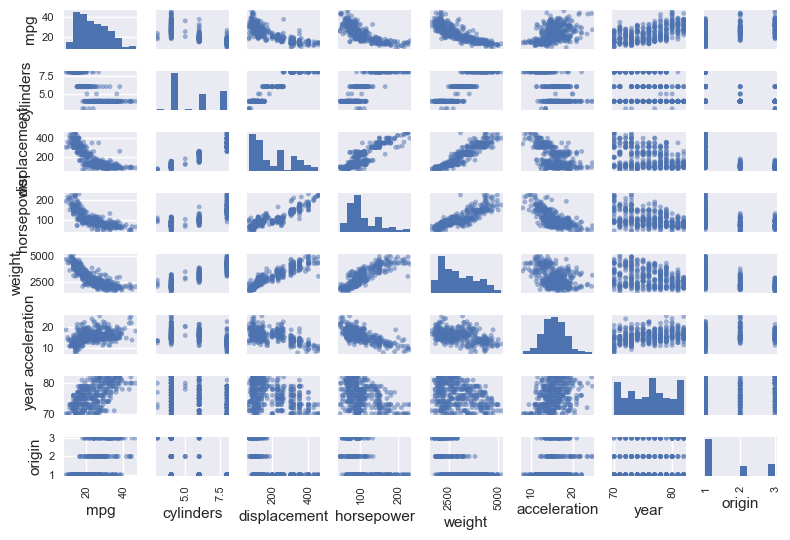

In [10]:
pd.plotting.scatter_matrix(data)
plt.tight_layout()
plt.show()

Non linear relationships are : 
1. displacement vs mpg
2. acceleration and horsepower
3. accelaration and mpg
4. horsepower and mpg

But these seem to be predominantly quadratic, so we can model it quite well using polynomial regression. 

Here the predictor is `mpg` and it has non linear relationships with cylinders, horsepower, accelaration and weight
- The features are pretty correlated so we can basically regress on only one feature `horsepower`

In [11]:
data.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


Finished 1 with RSS: 2657.00
Finished 2 with RSS: 2112.73
Finished 3 with RSS: 2131.73
Finished 4 with RSS: 2163.82
Finished 5 with RSS: 2136.87
Finished 6 with RSS: 2121.99
Finished 7 with RSS: 2095.12
Finished 8 with RSS: 2147.03
Finished 9 with RSS: 2297.53


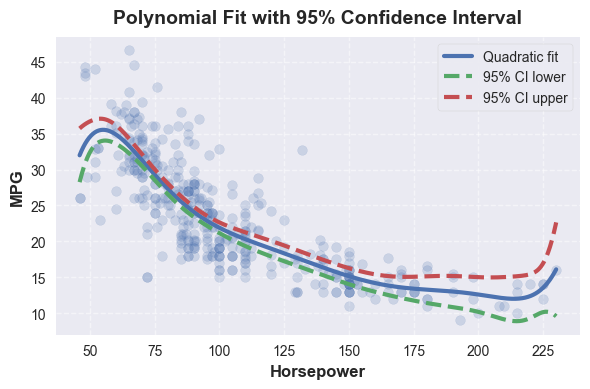

In [12]:
# Using CV to fit the polynomial degree mpg ~ horsepower
data = load_data("Auto")
y  = data["mpg"]
degree = np.arange(1, 10)
cv = ShuffleSplit(n_splits=split, test_size=0.3, random_state=42)
rss_vals = np.array([])

for i in degree : 
    x = MS([poly("horsepower", degree=i)]).fit(data)
    x = x.transform(data)
    rss = 0
    for train_idx, test_idx in cv.split(x) : 
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model = sm.OLS(y_train, x_train).fit()
        y_pred = model.predict(x_test)
        rss += np.sum((y_test - y_pred) ** 2)
    rss = rss / split
    rss_vals = np.append(rss_vals, rss)
    print(f"Finished {i} with RSS: {rss:.2f}")
    

design = MS([poly("horsepower", degree=7)]).fit(data)
x = design.transform(data)  
model = sm.OLS(y, x).fit()
horsedf = pd.DataFrame({'horsepower': np.linspace(data['horsepower'].min(), data['horsepower'].max(), 1000)})
x_new = design.transform(horsedf)
preds = model.get_prediction(x_new)
bands = preds.conf_int(alpha=0.05)

# Plotting
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(data['horsepower'], y, alpha=0.2)
for val, ls, label in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['-', '--', '--'], labels):
    ax.plot(np.linspace(data['horsepower'].min(), data['horsepower'].max(), 1000), val, ls=ls, linewidth=3, label=label)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Horsepower', fontsize=12, fontweight='bold')
ax.set_ylabel('MPG', fontsize=12, fontweight='bold')
ax.set_title('Polynomial Fit with 95% Confidence Interval', 
             fontsize=14, fontweight='bold', pad=10)
ax.legend(loc='upper right', framealpha=0.9, frameon=True, fontsize=10)
plt.style.use('seaborn-v0_8')
plt.tight_layout()
plt.show()

Finished 1 with RSS: 7000.32
Finished 2 with RSS: 4275.10
Finished 3 with RSS: 3778.27
Finished 4 with RSS: 2826.16
Finished 5 with RSS: 2500.94
Finished 6 with RSS: 2340.75
Finished 7 with RSS: 2412.30
Finished 8 with RSS: 2233.00
Finished 9 with RSS: 2297.54
Finished 10 with RSS: 2356.92
Finished 11 with RSS: 2293.39
Finished 12 with RSS: 2181.59
Finished 13 with RSS: 2288.72
Finished 14 with RSS: 2202.12
Finished 15 with RSS: 2143.10
Finished 16 with RSS: 2166.31
Finished 17 with RSS: 2186.45
Finished 18 with RSS: 2103.16
Finished 19 with RSS: 2155.21


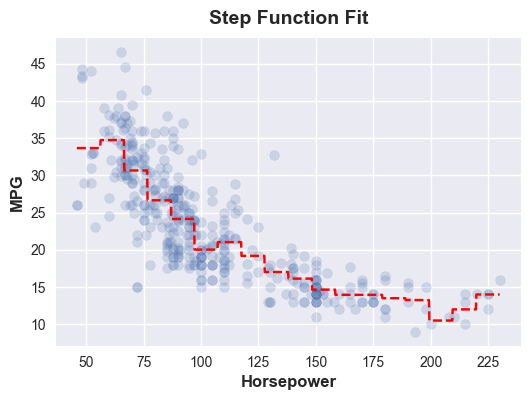

In [13]:
# Step function fit

knots = np.arange(1,20) # Selection from 1 - 20 knots
cv = ShuffleSplit(n_splits=split, test_size=0.3, random_state=42)
rss_vals = np.array([])
x = data["horsepower"]

for knot in knots : 
    rss = 0
    for train_idx, test_idx in cv.split(x) :
        cut_hp = pd.cut(x, knot)
        cut_hp = pd.get_dummies(cut_hp)
        x_train, x_test = cut_hp.iloc[train_idx], cut_hp.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model = sm.OLS(y_train, x_train).fit()
        y_pred = model.predict(x_test)
        rss += np.sum((y_test - y_pred) ** 2)
    rss = rss / split
    rss_vals = np.append(rss_vals, rss)
    print(f"Finished {knot} with RSS: {rss:.2f}")

# Using CV we get that 18 knots is the best.

# Model Fitting
cut_hp = pd.cut(x, 18)
cut_hp = pd.get_dummies(cut_hp)
model = sm.OLS(y, cut_hp).fit()
hp = np.linspace(data['horsepower'].min(), data['horsepower'].max(), 1000)
cut_hp_new = pd.cut(hp, 18)
cut_hp_new = pd.get_dummies(cut_hp_new)
preds = model.predict(cut_hp_new)

# Plotting
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(data['horsepower'], y, alpha=0.2)
plt.plot(hp, preds, "r--")
ax.set_xlabel('Horsepower', fontsize=12, fontweight='bold')
ax.set_ylabel('MPG', fontsize=12, fontweight='bold')
ax.set_title('Step Function Fit', 
             fontsize=14, fontweight='bold', pad=10)
plt.show()


Finished 1 with RSS: 2657.00
--------------------------------------------------
Finished 2 with RSS: 2095.04
--------------------------------------------------
Finished 3 with RSS: 2131.12
--------------------------------------------------
Finished 4 with RSS: 2127.29
--------------------------------------------------
Finished 5 with RSS: 2102.65
--------------------------------------------------
Finished 6 with RSS: 2098.54
--------------------------------------------------
Finished 7 with RSS: 2064.89
--------------------------------------------------
Finished 8 with RSS: 2087.61
--------------------------------------------------
Finished 9 with RSS: 2080.65
--------------------------------------------------
Finished 10 with RSS: 2104.91
--------------------------------------------------
Finished 11 with RSS: 2109.32
--------------------------------------------------
Finished 12 with RSS: 2133.13
--------------------------------------------------
Finished 13 with RSS: 2171.51
-------

Text(0.5, 1.0, 'NaturalSpline Fit with 95% Confidence Interval')

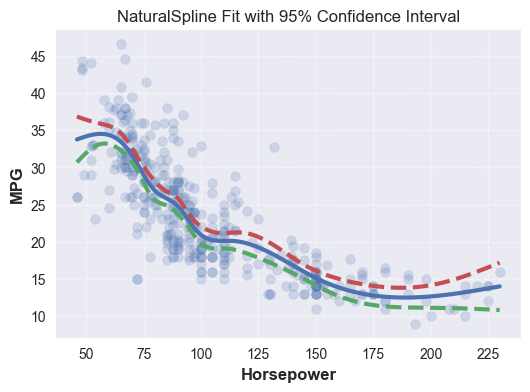

In [14]:
# Natural Spline with mpg ~ horsepower
degrees = np.arange(1,20)
cv = ShuffleSplit(n_splits=split, test_size=0.3, random_state=42)
rss_vals = np.array([])

for degree in degrees : 
    x = MS([ns("horsepower", df=degree)]).fit(data)
    x = x.transform(data)
    rss = 0
    for train_idx, test_idx in cv.split(x) : 
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model = sm.OLS(y_train, x_train).fit()
        y_pred = model.predict(x_test)
        rss += np.sum((y_test - y_pred) ** 2)
    rss = rss / split
    rss_vals = np.append(rss_vals, rss)
    print(f"Finished {degree} with RSS: {rss:.2f}")
    print("-" * 50)
    
# df = 7, gives us the minimum RSS
design = MS([ns("horsepower", df=7)]).fit(data)
x = design.transform(data)
model = sm.OLS(y, x).fit()
hp_new = pd.DataFrame({"horsepower" : hp})
x_new = design.transform(hp_new)
preds = model.get_prediction(x_new)
bands = preds.conf_int(alpha=0.05)

# Plotting
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(data['horsepower'], y, alpha=0.2)
for val, ls, label in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['-', '--', '--'], labels):
    ax.plot(hp, val, ls=ls, linewidth=3, label=label)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Horsepower', fontsize=12, fontweight='bold')
ax.set_ylabel('MPG', fontsize=12, fontweight='bold')
ax.set_title("NaturalSpline Fit with 95% Confidence Interval")

Whatever here we use in the natural splines and smoothing splines is different because s_splines primarily rely on regularization to control the behaviour whereas natural splines imposes linearity constraints 

### Question 3

Degree : 1 with RSS: 0.80
Degree : 2 with RSS: 0.58
Degree : 3 with RSS: 0.56
Degree : 4 with RSS: 0.56
Degree : 5 with RSS: 0.59
Degree : 6 with RSS: 0.81
Degree : 7 with RSS: 1.04
Degree : 8 with RSS: 1.01
Degree : 9 with RSS: 1.63


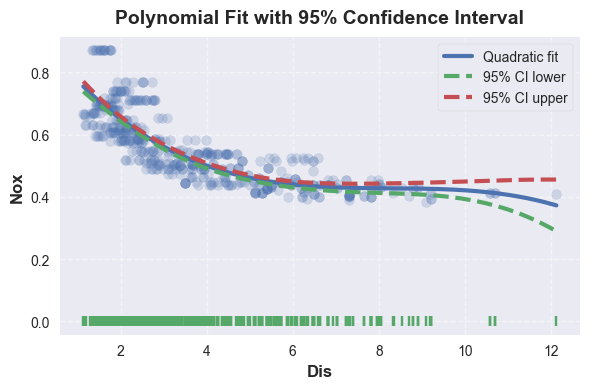

In [15]:
# nox ~ dis ( predictor ~ response )
data = load_data("Boston")
y = data["nox"]

# Polynomial Fit
degrees = np.arange(1, 10)
cv = ShuffleSplit(n_splits=split, test_size=0.3, random_state=42)

for degree in degrees : 
    x = MS([poly("dis", degree=degree)]).fit(data)
    x = x.transform(data)
    rss = 0
    for train_idx, test_idx in cv.split(x) : 
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model = sm.OLS(y_train, x_train).fit()
        y_pred = model.predict(x_test)
        rss += np.sum((y_test - y_pred) ** 2)
    rss = rss / split
    print(f"Degree : {degree} with RSS: {rss:.2f}")
    
# Minimum RSS we are getting at is degree 3, make sense cubic polynomial

# Model Construction
design = MS([poly("dis", degree=3)]).fit(data)
x = design.transform(data)
x_new = design.transform(pd.DataFrame({"dis" : np.linspace(data["dis"].min(), data["dis"].max(), 1000)}))
model = sm.OLS(y, x).fit()
preds = model.get_prediction(x_new)
bands = preds.conf_int(alpha=0.05)

# Plotting
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(data['dis'], y, alpha=0.2)
ax.scatter(data["dis"], np.zeros(data["dis"].shape[0]), marker = "|")
for val, ls, label in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['-', '--', '--'], labels):
    ax.plot(np.linspace(data['dis'].min(), data['dis'].max(), 1000), val, ls=ls, linewidth=3, label=label)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Dis', fontsize=12, fontweight='bold')
ax.set_ylabel('Nox', fontsize=12, fontweight='bold')
ax.set_title('Polynomial Fit with 95% Confidence Interval', 
             fontsize=14, fontweight='bold', pad=10)
ax.legend(loc='upper right', framealpha=0.9, frameon=True, fontsize=10)
plt.style.use('seaborn-v0_8')
plt.tight_layout()
plt.show()

Make sense that degree 3 i.e. cubic polynomial is a good fit but notice that once it has less data to fit, hence we get quite a wiggly fit towards the end of the data

Finished 3 with RSS: 0.56
--------------------------------------------------
Finished 4 with RSS: 0.56
--------------------------------------------------
Finished 5 with RSS: 0.54
--------------------------------------------------
Finished 6 with RSS: 0.54
--------------------------------------------------
Finished 7 with RSS: 0.55
--------------------------------------------------
Finished 8 with RSS: 0.55
--------------------------------------------------
Finished 9 with RSS: 0.55
--------------------------------------------------


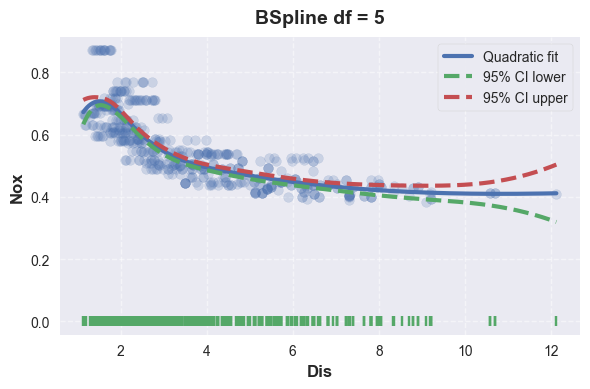

In [16]:
# BSpline
# Usally Knot selection is done based on quantile but i would prefer df here - easier

degrees = np.arange(3, 10)
cv = ShuffleSplit(n_splits=split, test_size=0.3, random_state=42)
rss_vals = np.array([])

for degree in degrees : 
    x_dis = MS([bs("dis", df = degree)]).fit(data)
    x_dis = x_dis.transform(data)
    rss = 0
    for train_idx, test_idx in cv.split(x_dis) : 
        x_train, x_test = x_dis.iloc[train_idx], x_dis.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model = sm.OLS(y_train, x_train).fit()
        y_pred = model.predict(x_test)
        rss += np.sum((y_test - y_pred) ** 2)
    rss = rss / split
    rss_vals = np.append(rss_vals, rss)
    print(f"Finished {degree} with RSS: {rss:.2f}")
    print("-" * 50)
    
# df = 5, gives us a good results
design = MS([bs("dis", df=5)]).fit(data)
x = design.transform(data)
x_new = design.transform(pd.DataFrame({"dis" : np.linspace(data["dis"].min(), data["dis"].max(), 1000)}))
model = sm.OLS(y, x).fit()
preds = model.get_prediction(x_new)
bands = preds.conf_int(alpha=0.05)
# Plotting
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(data['dis'], y, alpha=0.2)
ax.scatter(data["dis"], np.zeros(data["dis"].shape[0]), marker = "|")
for val, ls, label in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['-', '--', '--'], labels):
    ax.plot(np.linspace(data['dis'].min(), data['dis'].max(), 1000), val, ls=ls, linewidth=3, label=label)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Dis', fontsize=12, fontweight='bold')
ax.set_ylabel('Nox', fontsize=12, fontweight='bold')
ax.set_title('BSpline df = 5', 
             fontsize=14, fontweight='bold', pad=10)
ax.legend(loc='upper right', framealpha=0.9, frameon=True, fontsize=10)
plt.style.use('seaborn-v0_8')
plt.tight_layout()
plt.show()

Here what we did was pretty simple 
- Using CV got the right number of polynomial degree and degree of freedom

Results with a cubic polynomial and Bspline with df = 5, performs well with similar RSS values and being the best.

### Question 4

In [17]:
data = load_data("college")
data.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [18]:
def nCp(sigma, estimator, x, y): 
    n,p = x.shape
    y_hat = estimator.predict(x)
    rss = np.sum((y - y_hat)**2)
    return - (rss + 2*p*sigma) / n

In [19]:
# Split -> Outstate -> Stepwise -> GAM -> Evaluation

# Data Preprocessing
data = load_data("College")
cv = KFold(n_splits=2, shuffle=False)
train_idx, test_idx = next(cv.split(data))
train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]
design = MS(data.columns.drop("Outstate")).fit(data)
x_train, x_test = design.transform(train_data), design.transform(test_data)
y_train, y_test = train_data["Outstate"], test_data["Outstate"]

# Neg CP
y = data["Outstate"]
x = design.transform(data)
sigma = sm.OLS(y,x).fit().scale
neg_cp = partial(nCp, sigma)

# Defining Strategy
forward = Stepwise.first_peak(design, "forward", max_terms=len(design.terms))
college_mse = sklearn_selected(sm.OLS, forward, scoring=neg_cp)
college_mse.fit(train_data, y_train)
selected_states = college_mse.selected_state_
selected_states

('Expend',
 'Grad.Rate',
 'PhD',
 'Private',
 'Room.Board',
 'S.F.Ratio',
 'Top10perc',
 'perc.alumni')

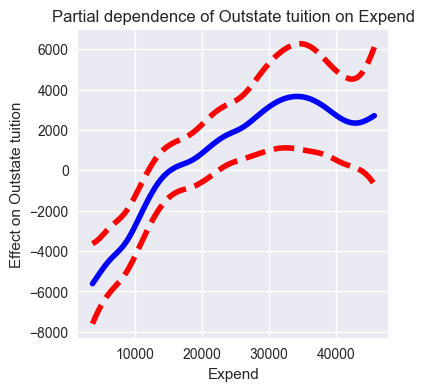

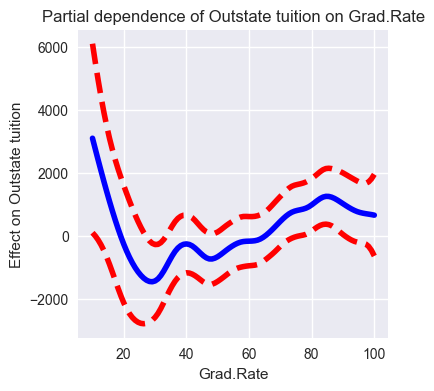

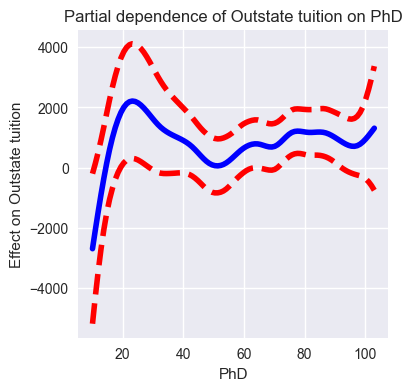

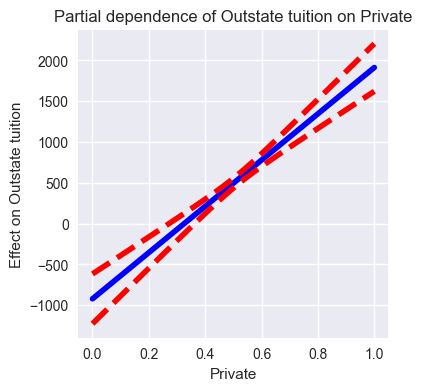

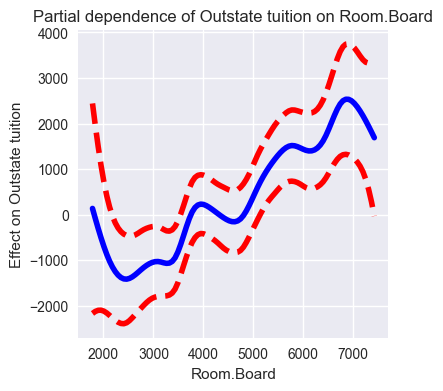

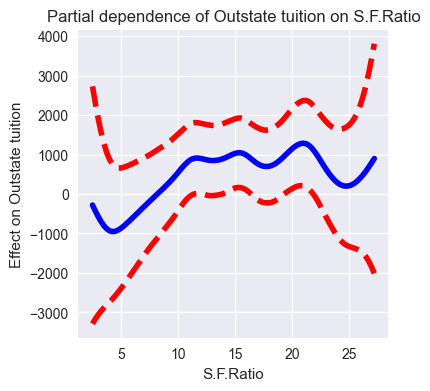

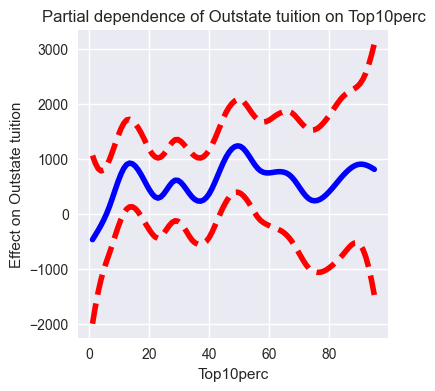

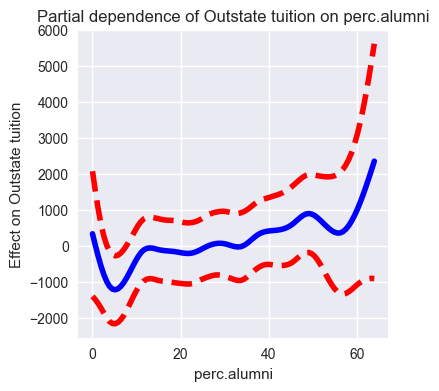

In [20]:
train = MS(selected_states, intercept=False).fit_transform(train_data)
test = MS(selected_states, intercept=False).fit_transform(test_data)

model = LinearGAM().fit(train, y_train)
preds = model.predict(test)
mse = np.mean((y_test - preds) ** 2)

# Plotting
for state in selected_states:
    selected = selected_states.index(state)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax = plot_gam(model, selected)
    ax.set_xlabel(state)
    ax.set_ylabel('Effect on Outstate tuition')
    ax.set_title(f'Partial dependence of Outstate tuition on {state}')

In [21]:
model.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     70.5502
Link Function:                     IdentityLink Log Likelihood:                                 -6164.1328
Number of Samples:                          388 AIC:                                             12471.366
                                                AICc:                                           12504.2776
                                                GCV:                                          4661668.5882
                                                Scale:                                        3166069.9257
                                                Pseudo R-Squared:                                   0.8414
Feature Function                  Lam

/var/folders/h3/pvdfbwyx1txcx5ftyxsw_chr0000gn/T/ipykernel_77874/3470139634.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  model.summary()


#### Tasks : 
- Constructing the transformation of BSplines and NaturalSplines from scractch for various knots and df
- Construction of Knots and choosing knots - using `pd.qcut()` but need to learn how to construct the basis functions and implement the whole thing

### Question 5

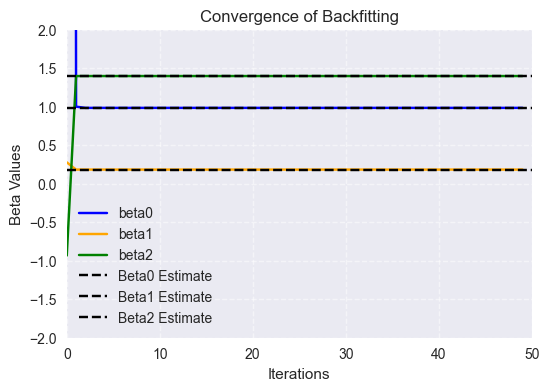

In [57]:
# Backfitting : Hold everything constant except one parameter. 

rng = np.random.default_rng(42)
n = 100
y = rng.normal(0, 1, n)
x1 = rng.normal(20, 8, n)
x2 = rng.normal(43, 24, n)
features = pd.DataFrame({"x1": x1, "x2": x2})
features_intercept = sm.add_constant(features)
betas = [0.5, 0.2, 1.4]
response = betas[0] + betas[1]*x1 + betas[2]*x2 + rng.normal(0, 1, n)

def simple_reg(outcome, feature) : 
    x = sm.add_constant(feature)
    model = sm.OLS(outcome, x).fit()
    return model.params[0], model.params[1]

beta1_vals = np.array([])
beta2_vals = np.array([])
beta0_vals = np.array([])

# Initialization
beta1 = 570
iterations = np.arange(50)
for i in iterations : 
    beta0, beta2 = simple_reg(response - beta1 * x1, x2)
    beta0, beta1 = simple_reg(response - beta2 * x2, x1)
    beta0_vals = np.append(beta0_vals, beta0)
    beta1_vals = np.append(beta1_vals, beta1)
    beta2_vals = np.append(beta2_vals, beta2)
    
# Converges pretty well
model = sm.OLS(response, features_intercept).fit()
beta0_est, beta1_est, beta2_est = model.params

# Plotting
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(iterations, beta0_vals, label='beta0', color='blue')
ax.plot(iterations,beta1_vals, label='beta1', color='orange')
ax.plot(iterations,beta2_vals, label='beta2', color='green')
ax.set_xlabel('Iterations')
ax.set_ylabel('Beta Values')
ax.set_title('Convergence of Backfitting')
ax.set_ylim(-2, 2)
ax.set_xlim(0, 50)
ax.grid(True, linestyle='--', alpha=0.5)
ax.axhline(y=beta0_est, color='black', linestyle='--', label='Beta0 Estimate')
ax.axhline(y=beta1_est, color='black', linestyle='--', label='Beta1 Estimate')
ax.axhline(y=beta2_est, color='black', linestyle='--', label='Beta2 Estimate')
ax.legend()
plt.show()


#### Question 6

In [72]:
np.random.seed(45)
predictors = 100
n = 100
x = np.random.rand(n,predictors)
constant = np.random.randn(1)
beta = np.random.randn(predictors)
epsilon = np.random.randn(n)
response = constant  + x@beta + epsilon

In [ ]:
data = pd.DataFrame(x, columns=[f"x{i}" for i in range(predictors)])
data_df = sm.add_constant(data)

In [138]:
# Backfitting : Need to understand more - especially matrix mul.
iterations = 100
mse = np.zeros(iterations)
c_hat = np.zeros((iterations, 1))  # Only one intercept for the whole model
beta_hat = np.zeros((iterations, predictors))

# Initialization
beta_hat[0, :] = np.random.randn(predictors)
c_hat[0, :] = np.random.randn(1)

# Algorithmn
# for i in iterations : 
    # beta0, beta2 = simple_reg(response - beta1 * x1, x2)
    # beta0, beta1 = simple_reg(response - beta2 * x2, x1)

# TODO : Need to improve more - Something is wrong
for j in range(iterations) : 
    for i in range(predictors) : 
        response_updated = response - (beta_hat[j,i] * x[:, i]) # Starting with one beta_i * x_i
        x_updated = np.delete(x, i, axis=1) # not fitting using x_i
        x_updated = sm.add_constant(x_updated)
        model = sm.OLS(response_updated, x_updated).fit()
        beta_hat[j,i] = model.params[1]
        c_hat[j] = model.params[0]
        mse[j] = np.sum((response - (c_hat[j] + x @ beta_hat[j])) ** 2)
    if j % 10 == 0:
        print(f"Iteration {j} completed")
        print(f"Current MSE: {mse[j]:.2f}")
        print("-" * 50)
        
    

Iteration 0 completed
Current MSE: 20205850.78
--------------------------------------------------
Iteration 10 completed
Current MSE: 22033778.05
--------------------------------------------------
Iteration 20 completed
Current MSE: 22033778.05
--------------------------------------------------
Iteration 30 completed
Current MSE: 22033778.05
--------------------------------------------------
Iteration 40 completed
Current MSE: 22033778.05
--------------------------------------------------
Iteration 50 completed
Current MSE: 22033778.05
--------------------------------------------------
Iteration 60 completed
Current MSE: 22033778.05
--------------------------------------------------
Iteration 70 completed
Current MSE: 22033778.05
--------------------------------------------------
Iteration 80 completed
Current MSE: 22033778.05
--------------------------------------------------
Iteration 90 completed
Current MSE: 22033778.05
--------------------------------------------------


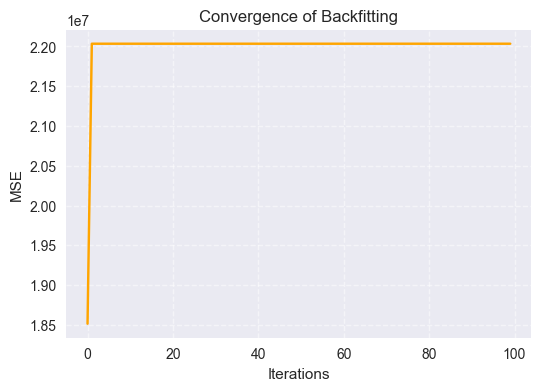

In [137]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(iterations), mse, label='MSE', color='orange')
ax.set_xlabel('Iterations')
ax.set_ylabel('MSE')
ax.set_title('Convergence of Backfitting')
ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [140]:
# Verification : Something is wrong, need to fix it.
cv = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, test_idx = next(cv.split(data_df))
train_data, test_data = data_df.iloc[train_idx], data_df.iloc[test_idx]
y_train, y_test = response[train_idx], response[test_idx]

model = sm.OLS(y_train, train_data).fit()
preds = model.predict(test_data)
mse = np.mean((y_test - preds) ** 2)
print(f"Mean Squared Error: {mse:.2f}")


Mean Squared Error: 9.93
